# Measuring the Hubble Constant with Cepheid Variables

## Learning Objectives

By the end of this project, you will be able to:
1. Explain how Cepheid variable stars serve as "standard candles" for measuring cosmic distances
2. Calibrate the Leavitt law (period-luminosity relation) using an anchor galaxy
3. Apply the distance ladder method to measure $H_0$
4. Quantify uncertainties in your measurement and compare to published values

## Background

The **Hubble constant** $H_0$ describes the current expansion rate of the Universe:

$$v = H_0 \cdot d$$

where $v$ is a galaxy's recession velocity and $d$ is its distance. Measuring $H_0$ requires:
1. **Distances** to galaxies (hard!)
2. **Redshifts** of those galaxies (easy - just spectroscopy)

The **Cepheid distance ladder** uses pulsating stars called Cepheids as "standard candles." Their pulsation period correlates with their intrinsic luminosity (the Leavitt law), so measuring the period tells us the absolute magnitude, and comparing to the apparent magnitude gives the distance.

## The Distance Ladder

```
Geometric distance (DEBs)  →  LMC Cepheids  →  Host galaxy Cepheids  →  H₀
       (anchor)                (calibrate)         (apply)            (fit)
```

We use data from the **SH0ES collaboration** (Riess et al. 2022), who measured $H_0 = 73.0 \pm 1.0$ km/s/Mpc.

Note that the actual SH0ES collaboration uses Pantheon+ supernovae with z>0.01 but for the purposes of this notebook and because we have yet to cover SNe in class, we do a simple 2 rung distance ladder Geometry --> Cepheids --> H0

---
## Part 1: Setup and Data Loading

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

# Plot settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [2]:
# Load the SH0ES Cepheid data
# Source: https://github.com/PantheonPlusSH0ES/DataRelease

cepheids = pd.read_csv(
    'data/cepheids_shoes.dat',
    delim_whitespace=True,
    comment='#'
)

print(f"Loaded {len(cepheids)} Cepheids in {cepheids['galaxy'].nunique()} galaxies")
print(f"\nColumns: {list(cepheids.columns)}")
print(f"\nFirst few rows:")
cepheids.head()

Loaded 2717 Cepheids in 40 galaxies

Columns: ['galaxy', 'period', 'W_H', 'W_H_err', 'metallicity']

First few rows:


,galaxy,period,W_H,W_H_err,metallicity
0,M101,6.8535,23.6774,0.4387,0.0525404
1,M101,6.8735,22.9405,0.6217,0.0890804
2,M101,6.9634,23.5218,0.7422,0.0886804
3,M101,7.2492,23.4408,0.4493,0.0834404
4,M101,7.2711,23.7346,0.6494,0.11477


### Understanding the Data

Each row is one Cepheid variable star. The columns are:

| Column | Description | Units |
|--------|-------------|-------|
| `galaxy` | Host galaxy name | - |
| `period` | Pulsation period | days |
| `W_H` | Wesenheit magnitude (apparent) | mag |
| `W_H_err` | Uncertainty in W_H | mag |
| `metallicity` (not used in this notebook) | [O/H] abundance | dex |

### What is the Wesenheit Magnitude?

Interstellar dust **dims** and **reddens** starlight. The extinction $A_\lambda$ (dimming in magnitudes) depends on wavelength — dust affects blue light more than red:

![Extinction Curve](data/extinction_curve.png)

*The Fitzpatrick (1999) extinction law with $R_V = 3.3$, showing how extinction decreases from optical (V, I) to near-infrared (H). The coefficient $R = A_H/E(V-I) = 0.386$ is computed by integrating over the actual HST filter bandpasses.*

### Why Wesenheit Magnitudes are "Reddening-Free"

The **Wesenheit magnitude** cleverly combines magnitudes to cancel out dust:

$$W_H = H - R \times (V - I), \quad R = 0.386$$

Here's why this works:

**For a dusty line of sight:**
- Observed H-band: $H = H_0 + A_H$ (dimmed by extinction $A_H$)
- Observed color: $(V-I) = (V-I)_0 + E(V-I)$ (reddened by color excess)

**Substituting into the Wesenheit formula:**
$$W_H = (H_0 + A_H) - R \times [(V-I)_0 + E(V-I)]$$
$$W_H = \underbrace{H_0 - R(V-I)_0}_{W_{H,0}} + \underbrace{A_H - R \times E(V-I)}_{\text{dust terms}}$$

**The key insight:** The coefficient $R$ is defined as $R \equiv A_H / E(V-I)$, so the dust terms cancel exactly:

$$A_H - R \times E(V-I) = A_H - \frac{A_H}{E(V-I)} \times E(V-I) = 0$$

Therefore: $W_H = W_{H,0}$ — **the true, dust-free Wesenheit magnitude!**

This is why Wesenheit magnitudes are powerful for distance measurements: we don't need to know how much dust lies along the line of sight, as long as the dust law is universal.

### Explore the Data

Before proceeding, let's understand our dataset.

In [6]:
# Compute log(Period) - we'll need this throughout
cepheids['logP'] = np.log10(cepheids['period'])

# Basic statistics
print("Period range: {:.1f} - {:.1f} days".format(
    cepheids['period'].min(), cepheids['period'].max()))
print("W_H range: {:.1f} - {:.1f} mag".format(
    cepheids['W_H'].min(), cepheids['W_H'].max()))

# How many Cepheids per galaxy?
print("\nCepheids per galaxy:")
print(cepheids.groupby('galaxy').size().describe())

Period range: 4.1 - 121.1 days
W_H range: -9.1 - 28.2 mag

Cepheids per galaxy:
count     40.000000
mean      67.925000
std       85.070826
min        8.000000
25%       21.750000
50%       36.500000
75%       73.000000
max      443.000000
dtype: float64


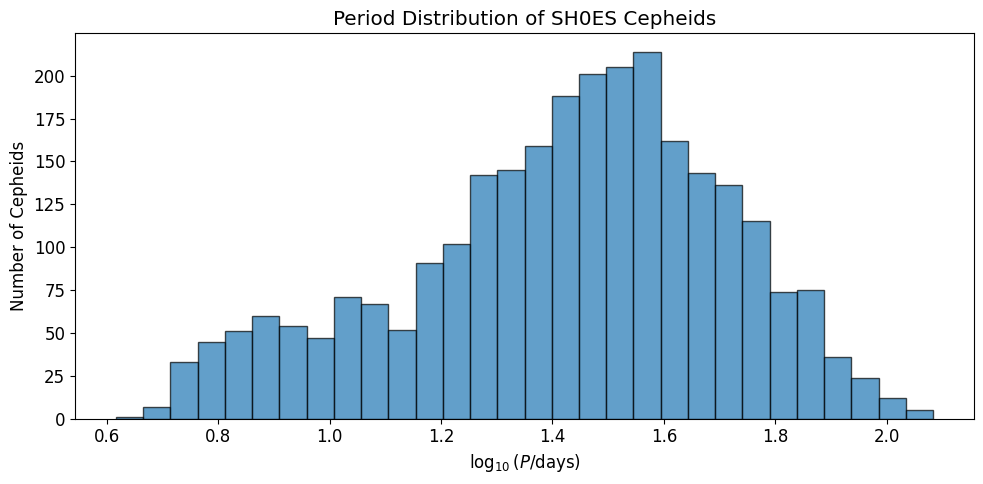

In [4]:
# Visualize the period distribution
plt.figure(figsize=(10, 5))
plt.hist(cepheids['logP'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(r'$\log_{10}(P/\mathrm{days})$')
plt.ylabel('Number of Cepheids')
plt.title('Period Distribution of SH0ES Cepheids')
plt.tight_layout()
plt.show()

---
## Part 2: Calibrate the Leavitt Law with LMC

### The Leavitt Law (Period-Luminosity Relation)

Henrietta Leavitt discovered in 1912 that Cepheid **absolute magnitude** correlates with **period**:

$$M = a \cdot (\log_{10} P - 1) + b$$

where:
- $M$ = absolute magnitude (intrinsic brightness)
- $P$ = pulsation period in days
- $a \approx -3.25$ mag/dex = slope (brighter at longer periods)
- $b$ = zeropoint (absolute magnitude at $P = 10$ days. The "$-1$" centers the relation at $P = 10$ days, which minimizes correlation between slope and zeropoint uncertainties.)



### Why LMC as the Anchor?

To calibrate the Leavitt law, we need Cepheids at a **known distance**. The Large Magellanic Cloud (LMC) is ideal because:
1. Close enough to observe many Cepheids (~50 kpc)
2. Distance measured geometrically using **detached eclipsing binaries** (DEBs)
3. Same photometric system as host galaxies (HST)

The geometric LMC distance modulus is:

$$\mu_{\rm LMC} = 18.477 \pm 0.026 \text{ mag}$$

(Pietrzyński et al. 2019, Nature)

### Extract LMC Cepheids and Convert to Absolute Magnitudes

1. Select only the Cepheids in the LMC (`galaxy == 'LMC'`)
2. Convert apparent magnitudes to absolute using: $M = m - \mu$

Why? Because we will use these absolute magnitudes to calibrate the Leavitt Law.

In [ ]:
# Task 1: Extract LMC Cepheids and Convert to Absolute Magnitudes
# ═══════════════════════════════════════════════════════════════════════════

# LMC distance modulus (geometric, from eclipsing binaries)
MU_LMC = 18.477      # mag
MU_LMC_ERR = 0.026   # mag

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝


### Fit the Leavitt Law

Fit the period-luminosity relation: $M = a \cdot (\log P - 1) + b$

Remember to use actual error bars (not relative weights).

In [ ]:
# Task 2: Fit the Leavitt Law
# ═══════════════════════════════════════════════════════════════════════════

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

def leavitt_law():
    asdf

Fit

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝


In [ ]:
# Task 3: Visualize the Leavitt law fit

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

### Understanding the Fit

**Question:** Why is the slope negative? What does this tell us about Cepheid physics?

```
# Task 4
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR ANSWER BELOW ↓↓↓                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR ANSWER ABOVE ↑↑↑                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
```


### Apply Leavitt Law to Host Galaxies

1. Select all Cepheids NOT in the LMC (these are our "host galaxies")
2. Predict absolute magnitude using your fitted Leavitt law
3. Calculate distance modulus: $\mu = W_H - M_{\rm pred}$
4. Convert to distance in Mpc (`d_Mpc = 10**((mu + 5) / 5) / 1e6`)

In [ ]:
# Task 5: Apply Leavitt Law to Host Galaxies
# ═══════════════════════════════════════════════════════════════════════════

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝


### Average Distance per Galaxy

Each galaxy has multiple Cepheids, giving multiple distance estimates. We should combine them using a **weighted average**, where more precise measurements get more weight:

$$\bar{\mu} = \frac{\sum_i w_i \mu_i}{\sum_i w_i}, \quad w_i = \frac{1}{\sigma_i^2}$$

The uncertainty on the weighted mean is:

$$\sigma_{\bar{\mu}} = \frac{1}{\sqrt{\sum_i w_i}}$$


---
## Now Get Redshifts from SIMBAD

To measure $H_0$, we need recession velocities (redshifts) for each galaxy. We'll query the **SIMBAD** astronomical database.


In [10]:
# SIMBAD query setup (provided - no modifications needed)
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u
import warnings

C_KMS = 299792.458  # Speed of light in km/s

# This is for your reference because SIMBAD uses different names to SH0ES...
name_map = {
    'M101': 'M101', 'N4258': 'NGC 4258', 'N1365': 'NGC 1365',
    'N1448': 'NGC 1448', 'N4536': 'NGC 4536', 'N4639': 'NGC 4639',
    'N3370': 'NGC 3370', 'N3982': 'NGC 3982', 'N4038': 'NGC 4038',
    'N4424': 'NGC 4424', 'N5584': 'NGC 5584', 'N5917': 'NGC 5917',
    'N7250': 'NGC 7250', 'N3021': 'NGC 3021', 'N3447': 'NGC 3447',
    'N1309': 'NGC 1309', 'N3972': 'NGC 3972', 'N7329': 'NGC 7329',
    'N0691': 'NGC 691', 'N2442': 'NGC 2442', 'N1015': 'NGC 1015',
    'N0976': 'NGC 976', 'N0105': 'NGC 105', 'N4680': 'NGC 4680',
    'N2525': 'NGC 2525', 'N1559': 'NGC 1559', 'N3254': 'NGC 3254',
    'N7541': 'NGC 7541', 'N7678': 'NGC 7678', 'N5643': 'NGC 5643',
    'N3147': 'NGC 3147', 'U9391': 'UGC 9391', 'M1337': 'NGC 1337',
    'N2608': 'NGC 2608',
}

def query_redshift_and_coords(galaxy_name):
    """Query SIMBAD for a galaxy's heliocentric radial velocity and coordinates."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            query = f"""
            SELECT TOP 1 b.rvz_radvel, b.ra, b.dec
            FROM ident AS i
            JOIN basic AS b ON i.oidref = b.oid
            WHERE i.id = '{galaxy_name}'
            """
            result = Simbad.query_tap(query)
        
        if result is None or len(result) == 0:
            return None, None, None
        
        rv = result['rvz_radvel'][0]
        ra = result['ra'][0]
        dec = result['dec'][0]
        
        if rv is None or np.ma.is_masked(rv):
            return None, ra, dec
        
        return float(rv), float(ra), float(dec)
    except:
        return None, None, None

In [11]:
# Task 6: get the redshifts from SIMBAD
# ═══════════════════════════════════════════════════════════════════════════

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

### Redshift and Recession Velocity

At low redshift ($z \ll 1$), the recession velocity is:

$$v = c \cdot z$$

where $c = 299792$ km/s is the speed of light.

### Cosmic Rest Frame Correction

Nearby galaxies don't just follow the Hubble flow—they have **peculiar velocities** from gravitational interactions with local structure (Virgo, Great Attractor, etc.).

**See Figure 15 in Courtois et al. (Cosmicflows):**
https://iopscience.iop.org/article/10.1088/0004-6256/146/3/69

Key features:
- Galaxies flow toward massive attractors (Virgo, Great Attractor, Shapley)
- The MW moves at ~370 km/s relative to the CMB
- Nearby galaxies have $v_{\rm pec} \sim 300$–$500$ km/s that must be corrected


SIMBAD provides **heliocentric** velocities (measured relative to the Sun). But the Sun itself is moving at ~370 km/s relative to the **cosmic** rest frame — the frame where the Universe appears isotropic.

We must correct for this motion (best measured from the CMB dipole):
$$v_{\rm CMB} = v_{\rm helio} + v_\odot \cos\theta$$

where $v_\odot = 369.82$ km/s is the Sun's speed toward $(l, b) = (264°, 48°)$ and $\theta$ is the angle between the galaxy and this direction.

In [9]:
# CMB dipole: Sun's motion relative to CMB rest frame
# From Planck 2018: v = 369.82 km/s toward (l, b) = (264.021°, 48.253°)
CMB_VELOCITY = 369.82  # km/s
CMB_L = 264.021  # Galactic longitude (degrees)
CMB_B = 48.253   # Galactic latitude (degrees)

# CMB dipole direction as a unit vector
cmb_dir = SkyCoord(l=CMB_L*u.deg, b=CMB_B*u.deg, frame='galactic')

def helio_to_cmb(v_helio, ra, dec):
    """
    Convert heliocentric velocity to CMB rest frame.
    
    The Sun moves at ~370 km/s relative to the CMB. We need to add the 
    component of this motion along the line of sight to each galaxy.
    
    v_CMB = v_helio + v_sun * cos(theta)
    
    where theta is the angle between the galaxy and the CMB dipole direction.
    """
    # Task 7: Convert heliocentric velocity to CMB rest frame.
    # ═══════════════════════════════════════════════════════════════════════════
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    
    
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    return v_helio + v_correction, v_correction

NameError: name 'SkyCoord' is not defined

### Remove erronious data

Exclude:
- Galaxies without redshifts (`z` is NaN)
- Galaxies with $z < 0.001$ (peculiar velocities dominate)

In [ ]:
# Task 8: Select Galaxies in the Hubble Flow
# ═══════════════════════════════════════════════════════════════════════════

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝


### Important: Residual Peculiar Velocities

Even after CMB correction, nearby galaxies have significant **peculiar velocities** (random motions ~300-500 km/s) that contaminate the Hubble flow. We'll exclude galaxies with $z < 0.001$ ($v < 500$ km/s) where peculiar velocities dominate. This will come into play below ($\sigma_{\rm pec}$)

---
## Build the Hubble Diagram and Measure $H_0$

### Hubble's Law

At low redshift, the Universe expands linearly:

$$v = H_0 \cdot d$$

We'll fit for $H_0$ using **Markov Chain Monte Carlo (MCMC)**, a method that samples the posterior probability distribution of parameters.

### Error Model

Each galaxy has two sources of uncertainty:
1. **Distance uncertainty** from Cepheid measurements ($\sigma_\mu$)
2. **Peculiar velocity** (~500 km/s random motions)

The total velocity uncertainty for galaxy $i$ is:

$$\sigma_{v,i}^2 = (H_0 \cdot \sigma_{d,i})^2 + \sigma_{\rm pec}^2$$

note that since your error on velocity is dependent on our fitted cosmological parameter (H0), the uncertainties cannot be hardcoded. 

In [ ]:
# Task 9: Visualize the raw Hubble diagram before fitting
# ═══════════════════════════════════════════════════════════════════════════

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

### Set Up an MCMC

We'll use `emcee`, a popular Python MCMC sampler. The key ingredients are:

1. **Log-likelihood function**: measures how well a model fits the data
2. **Log-prior function**: encodes prior beliefs (we'll use flat priors)
3. **Log-posterior**: sum of log-likelihood and log-prior

**Hint:** For Gaussian errors, the log-likelihood is:
$$\ln \mathcal{L} = -\frac{1}{2} \sum_i \left[ \frac{(v_i - H_0 d_i)^2}{\sigma_{v,i}^2} + \ln(2\pi\sigma_{v,i}^2) \right]$$

In [ ]:
# Task 10: Set Up the MCMC Log-Likelihood
# ═══════════════════════════════════════════════════════════════════════════

import emcee
import corner

def log_likelihood(theta):
    """Log-likelihood for Hubble's law: v = H0 * d"""
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    return 

def log_prior(theta):
    """Flat prior on H0 between 0 and 200 km/s/Mpc"""
    H0 = theta[0]
    if 0 < H0 < 200:
        return 0.0
    return -np.inf

def log_posterior(theta):
    """Log-posterior = log-prior + log-likelihood"""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


In [ ]:
# Run the MCMC sampler
print("Running MCMC...")

# Set up the sampler
ndim = 1        # Number of parameters (just H0)
nwalkers = 32   # Number of walkers (parallel chains)
nsteps = 2000   # Number of steps per walker

# Initialize walkers in a small ball around our guess
np.random.seed(42)
p0 = 70.0 + 5.0 * np.random.randn(nwalkers, ndim)

# Create and run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, nsteps, progress=True)

print("Done!")

NameError: name 'sampler' is not defined

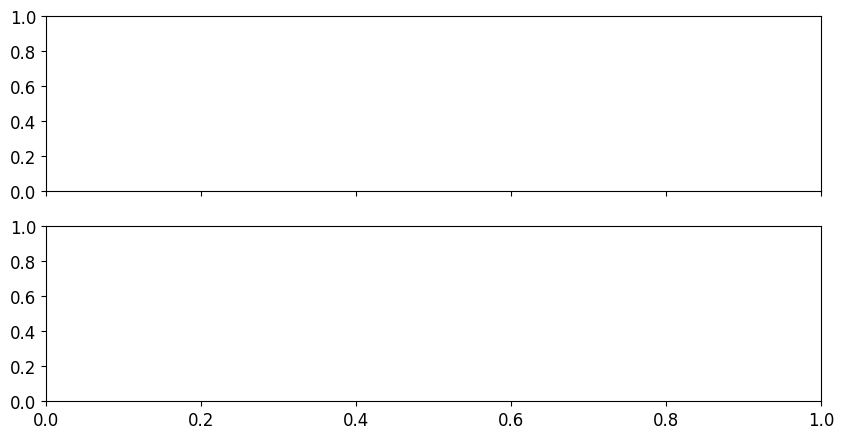

In [12]:
# Check convergence: plot the chains (trace plot)
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot all walkers
samples_full = sampler.get_chain()
for i in range(nwalkers):
    axes[0].plot(samples_full[:, i, 0], alpha=0.3, color='steelblue')
axes[0].axhline(70, color='gray', ls='--', alpha=0.5)
axes[0].set_ylabel(r'$H_0$ [km/s/Mpc]')
axes[0].set_title('MCMC Trace Plot (all walkers)')

# Plot log-probability
log_prob = sampler.get_log_prob()
for i in range(nwalkers):
    axes[1].plot(log_prob[:, i], alpha=0.3, color='steelblue')
axes[1].set_ylabel('Log-posterior')
axes[1].set_xlabel('Step')

plt.tight_layout()
plt.show()

# Check: walkers should converge to similar values after "burn-in"
print("Look for: walkers converging to the same region after initial 'burn-in' phase")

In [ ]:
# Discard burn-in and flatten chains
burn_in = 500  # Discard first 500 steps
samples = sampler.get_chain(discard=burn_in, flat=True)

print(f"Total samples after burn-in: {len(samples)}")

# Extract H0 statistics from posterior
H0_samples = samples[:, 0]
H0_median = np.median(H0_samples)
H0_low, H0_high = np.percentile(H0_samples, [16, 84])  # 1-sigma interval
H0_err = (H0_high - H0_low) / 2

print("=" * 60)
print(f"  YOUR MEASUREMENT: H0 = {H0_median:.1f} ± {H0_err:.1f} km/s/Mpc")
print(f"  (68% credible interval: [{H0_low:.1f}, {H0_high:.1f}])")
print("=" * 60)
print(f"\nCompare to published values:")
print(f"  SH0ES (Cepheids + SNe Ia):  73.0 ± 1.0 km/s/Mpc")
print(f"  Planck (CMB):               67.4 ± 0.5 km/s/Mpc")

### Now Visualize the Hubble diagram and fitted H0 slope uncertainty

In [ ]:
# Task 11: Visualize the Hubble diagram and fitted H0 uncertainty
# ═══════════════════════════════════════════════════════════════════════════

# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝



# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

---
## Understanding the Anchor Distance Systematic

### The Problem: Correlated vs Independent Errors

Our current error model includes:
- **Independent errors**: Each galaxy's Cepheid measurement scatter (random, uncorrelated)
- **Peculiar velocities**: Random motions (~500 km/s, uncorrelated between galaxies)

But we're **missing** a crucial error source: the **anchor distance uncertainty** ($\sigma_{\mu,{\rm LMC}} = 0.026$ mag).

### Why This Matters

The LMC distance modulus $\mu_{\rm LMC}$ sets the **absolute calibration** of our distance ladder. If $\mu_{\rm LMC}$ is wrong, then ALL host galaxy distances shift by the **same fractional amount** — this is a **correlated systematic** that doesn't average down with more galaxies!

### The Solution: Add $\mu_{\rm LMC}$ as a Nuisance Parameter

Instead of fixing $\mu_{\rm LMC} = 18.477$, we treat it as a **nuisance parameter** in our MCMC with a Gaussian prior:

$$\mu_{\rm LMC} \sim \mathcal{N}(18.477, 0.026^2)$$

### Updated Likelihood

When $\mu_{\rm LMC}$ changes by $\delta\mu = \mu_{\rm LMC} - 18.477$ from our fiducial value, all distances scale:

$$d_i^{\rm corrected} = d_i \times 10^{\delta\mu/5}$$

The full log-likelihood becomes:

$$\ln \mathcal{L}(H_0, \mu_{\rm LMC}) = -\frac{1}{2} \sum_i \left[ \frac{(v_i - H_0 \, d_i^{\rm corrected})^2}{\sigma_{v,i}^2} + \ln(2\pi\sigma_{v,i}^2) \right]$$

where $\sigma_{v,i}^2 = (H_0 \cdot \sigma_{d,i}^{\rm corrected})^2 + \sigma_{\rm pec}^2$

### Updated Prior

The log-prior now includes a Gaussian constraint on $\mu_{\rm LMC}$:

$$\ln P(H_0, \mu_{\rm LMC}) = \begin{cases} 
-\frac{1}{2}\left(\frac{\mu_{\rm LMC} - 18.477}{0.026}\right)^2 & \text{if } 0 < H_0 < 200 \\
-\infty & \text{otherwise}
\end{cases}$$

### Why This Works

The MCMC now explores the **joint posterior** $P(H_0, \mu_{\rm LMC} \,|\, \text{data})$. The final $H_0$ uncertainty automatically includes the anchor contribution through the covariance between parameters.


### Student Task 7: Add $\mu_{\rm LMC}$ as a Nuisance Parameter

Modify your MCMC to marginalize over the anchor distance:

1. **Expand the parameter vector**: $\theta = [H_0, \mu_{\rm LMC}]$ (now 2D instead of 1D)
2. **Update the likelihood**: Recompute distances using the sampled $\mu_{\rm LMC}$
3. **Add a Gaussian prior** on $\mu_{\rm LMC}$: $\mathcal{N}(18.477, 0.026^2)$



In [ ]:
# Task 12: Implement Anchor Marginalization
# ═══════════════════════════════════════════════════════════════════════════

def log_likelihood_with_anchor(theta):
    """
    Log-likelihood that properly marginalizes over anchor distance.
    
    Parameters:
        theta[0] = H0 (km/s/Mpc)
        theta[1] = mu_LMC (mag) - the anchor distance modulus
    """
    H0, mu_LMC = theta
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    
    pass  # Replace with return statement

def log_prior_with_anchor(theta):
    """
    Prior: flat on H0, Gaussian on mu_LMC
    """
    H0, mu_LMC = theta
    
    # Flat prior on H0
    if not (0 < H0 < 200):
        return -np.inf
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↓↓↓ YOUR CODE BELOW ↓↓↓                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
                                                                                                                
    log_prior_mu = # Gaussian prior on mu_LMC: N(18.477, 0.026^2)                                                                                                                                                                                  
    
    # ╔═══════════════════════════════════════════════════════════════════════════╗
    # ║                        ↑↑↑ YOUR CODE ABOVE ↑↑↑                            ║
    # ╚═══════════════════════════════════════════════════════════════════════════╝
    
    return log_prior_mu     

def log_posterior_with_anchor(theta):
    lp = log_prior_with_anchor(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_with_anchor(theta)

print("Define the functions above, then run the MCMC below!")


In [ ]:
# Run MCMC with anchor marginalization (provided)
print("Running MCMC with proper anchor treatment...")

ndim_anchor = 2  # H0 and mu_LMC
nwalkers_anchor = 32
nsteps_anchor = 2000

# Initialize: H0 near 70, mu_LMC near 18.477
np.random.seed(42)
p0_anchor = np.column_stack([
    70.0 + 5.0 * np.random.randn(nwalkers_anchor),
    18.477 + 0.026 * np.random.randn(nwalkers_anchor)
])

sampler_anchor = emcee.EnsembleSampler(nwalkers_anchor, ndim_anchor, log_posterior_with_anchor)
sampler_anchor.run_mcmc(p0_anchor, nsteps_anchor, progress=True)

# Extract results
samples_anchor = sampler_anchor.get_chain(discard=500, flat=True)
H0_samples_anchor = samples_anchor[:, 0]
mu_samples = samples_anchor[:, 1]

H0_median_anchor = np.median(H0_samples_anchor)
H0_low_anchor, H0_high_anchor = np.percentile(H0_samples_anchor, [16, 84])
H0_err_anchor = (H0_high_anchor - H0_low_anchor) / 2

print("\n" + "=" * 70)
print("  WITH ANCHOR MARGINALIZATION:")
print(f"  H0 = {H0_median_anchor:.1f} ± {H0_err_anchor:.1f} km/s/Mpc")
print("=" * 70)
print(f"\nCompare to fixed-anchor result: H0 = {H0_median:.1f} ± {H0_err:.1f} km/s/Mpc")
print(f"Error increase: {H0_err_anchor:.2f} vs {H0_err:.2f} km/s/Mpc")
print(f"\nThe ~1.2% anchor systematic is now properly included!")

In [ ]:
# Corner plot: visualize the joint posterior P(H0, mu_LMC | data)
fig = corner.corner(
    samples_anchor, 
    labels=[r"$H_0$ [km/s/Mpc]", r"$\mu_{\rm LMC}$ [mag]"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),  # 1σ and 2σ contours
)

# Add reference lines
axes = np.array(fig.axes).reshape((2, 2))
axes[1, 1].axvline(18.477, color='red', ls='--', lw=1.5, alpha=0.7)
axes[1, 1].axvspan(18.477-0.026, 18.477+0.026, color='red', alpha=0.2)

plt.suptitle('Joint Posterior: $H_0$ and Anchor Distance $\mu_{\mathrm{LMC}}$', y=1.02, fontsize=14)
plt.show()

---
## Summary and Discussion

### What You Accomplished

1. **Calibrated the Leavitt law** from 69 LMC Cepheids using the geometric DEB distance
2. **Measured distances** to 39 host galaxies using your calibrated period-luminosity relation
3. **Queried SIMBAD** for redshifts and built a Hubble diagram
4. **Fit $H_0$ using MCMC** with proper treatment of distance and peculiar velocity uncertainties
5. **Visualized the posterior** with a corner plot

### MCMC Concepts You Learned

- **Likelihood function**: quantifies how well the model fits the data
- **Prior**: encodes prior knowledge (we used a flat prior on $H_0$)
- **Posterior**: the probability distribution of parameters given the data
- **Burn-in**: initial steps where walkers haven't yet converged (discarded)
- **Credible interval**: Bayesian analog of confidence interval (68% = 1σ)

### Further Reading

- Riess et al. 2022, ApJL 934, L7 — The SH0ES $H_0$ measurement
- Pietrzyński et al. 2019, Nature 567, 200 — Geometric LMC distance
- Foreman-Mackey et al. 2013, PASP 125, 306 — The `emcee` paper
- Di Valentino et al. 2021, CQG 38, 153001 — Review of the Hubble tension

# Bonus Points

1. **How much is the recovered $H_0$ sensitive to other various quantities (HST calibration, peculiar velocities, redshift errors, etc...)?**  

2. **What if we lived in a cosmic void?**  
